=== TRAINING DQN (discrete) ===
[DQN ep 1/420] explore_frac=1.00 exploit_frac=0.00
[DQN ep 2/420] explore_frac=1.00 exploit_frac=0.00
[DQN ep 3/420] explore_frac=1.00 exploit_frac=0.00
[DQN ep 4/420] explore_frac=1.00 exploit_frac=0.00
[DQN ep 5/420] explore_frac=1.00 exploit_frac=0.00
[DQN ep 6/420] explore_frac=0.98 exploit_frac=0.02
[DQN ep 7/420] explore_frac=0.98 exploit_frac=0.02
[DQN ep 8/420] explore_frac=1.00 exploit_frac=0.00
[DQN ep 9/420] explore_frac=1.00 exploit_frac=0.00
[DQN ep 10/420] explore_frac=0.98 exploit_frac=0.02
[DQN ep 11/420] explore_frac=0.98 exploit_frac=0.02
[DQN ep 12/420] explore_frac=0.98 exploit_frac=0.02
[DQN ep 13/420] explore_frac=0.96 exploit_frac=0.04
[DQN ep 14/420] explore_frac=0.92 exploit_frac=0.08
[DQN ep 15/420] explore_frac=0.96 exploit_frac=0.04
[DQN ep 16/420] explore_frac=0.98 exploit_frac=0.02
[DQN ep 17/420] explore_frac=1.00 exploit_frac=0.00
[DQN ep 18/420] explore_frac=1.00 exploit_frac=0.00
[DQN ep 19/420] explore_frac=0.90 exploit

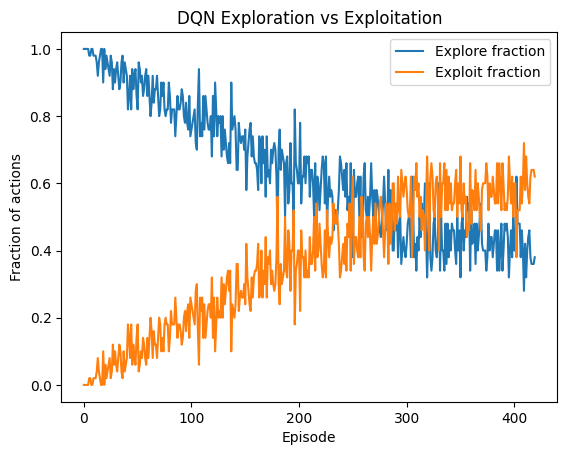

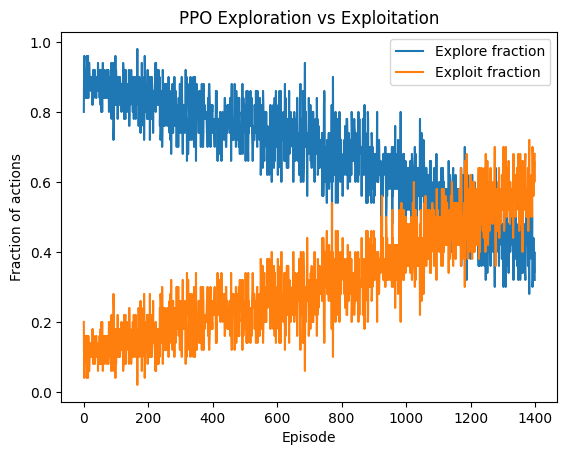

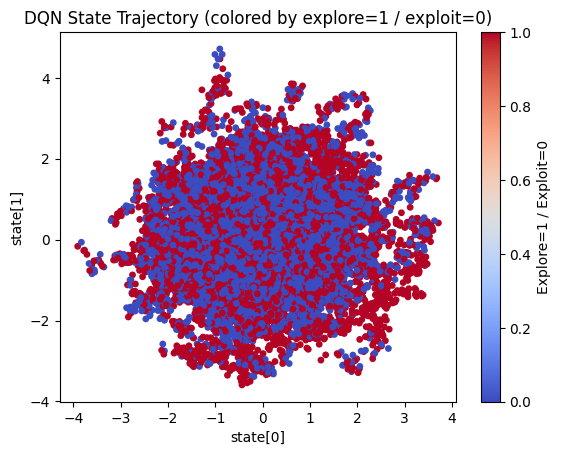

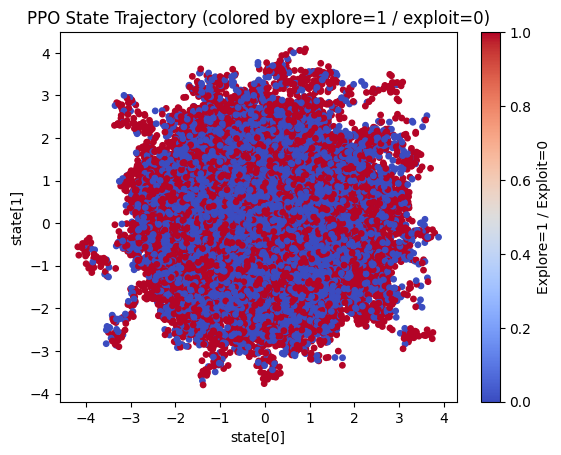

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque, namedtuple
import matplotlib.pyplot as plt


# ============================================================
# 0. Utilities
# ============================================================

def safe_variance_from_counts(N: np.ndarray):
    """
    Safe replacement for variance = 1/N, without divide-by-zero warnings.
    """
    variance = np.ones_like(N, dtype=float)
    mask = N > 0
    variance[mask] = 1.0 / N[mask]
    if not np.all(np.isfinite(variance)):
        raise ValueError("Non-finite values in variance computation.")
    return variance

def check_finite_tensor(t, name="tensor"):
    if not torch.isfinite(t).all():
        raise ValueError(f"Non-finite values detected in {name}")

def check_finite_np(x, name="array"):
    if not np.isfinite(x).all():
        raise ValueError(f"Non-finite values detected in {name}")


# ============================================================
# 1. Environment
# ============================================================

class DummyEnv:
    """
    Minimal toy env.

    - Observation: 4D vector, drifts randomly each step.
    - Episode ends after max_t steps.
    - Discrete mode (for DQN): action ∈ {0,1,2,3}; reward = +1 if action==2 else 0.
    - Continuous mode (for PPO): action ∈ R^2; reward = -||action|| (small norm = better).
    """

    def __init__(self, discrete=True):
        self.discrete = discrete
        self.t = 0
        self.max_t = 50
        self.state_dim = 4
        self.action_dim = 4 if discrete else 2
        self.state = np.zeros(self.state_dim, dtype=np.float32)

    def reset(self):
        self.t = 0
        self.state = np.random.randn(self.state_dim).astype(np.float32)
        return self.state

    def step(self, action):
        self.t += 1

        # small random walk in state
        self.state = self.state + 0.1 * np.random.randn(self.state_dim).astype(np.float32)

        # reward function differs by mode
        if self.discrete:
            reward = 1.0 if action == 2 else 0.0
        else:
            # reward = -magnitude of action vector
            if isinstance(action, np.ndarray):
                reward = float(-np.linalg.norm(action))
            else:
                reward = float(-np.linalg.norm(action.detach().cpu().numpy()))

        done = self.t >= self.max_t
        info = {}
        return self.state, reward, done, info


# ============================================================
# 2. DQN Components
# ============================================================

class QNetwork(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super().__init__()
        self.fc1 = nn.Linear(obs_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)  # Q-values for each action


Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'done'))


class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))

    def __len__(self):
        return len(self.buffer)


def dqn_select_action(q_net, state, epsilon, n_actions, device):
    """
    ε-greedy.
    Returns:
      action (int),
      explore_flag (True if random, False if greedy),
      greedy_action (the argmax Q action for logging)
    """
    with torch.no_grad():
        s = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        q = q_net(s)
        greedy_action = int(q.argmax(dim=1).item())

    if random.random() < epsilon:
        # explore: random
        a = random.randrange(n_actions)
        return a, True, greedy_action
    else:
        # exploit: take argmax
        return greedy_action, False, greedy_action


def dqn_update(q_net, target_net, optimizer, batch, gamma, device):
    """
    One TD update for DQN.
    """
    state      = torch.tensor(np.array(batch.state), dtype=torch.float32, device=device)
    action     = torch.tensor(batch.action, dtype=torch.int64, device=device).unsqueeze(1)
    reward     = torch.tensor(batch.reward, dtype=torch.float32, device=device).unsqueeze(1)
    next_state = torch.tensor(np.array(batch.next_state), dtype=torch.float32, device=device)
    done       = torch.tensor(batch.done, dtype=torch.float32, device=device).unsqueeze(1)

    q_values = q_net(state).gather(1, action)

    with torch.no_grad():
        next_q_online = q_net(next_state)
        best_a = next_q_online.argmax(dim=1, keepdim=True)
        next_q_target = target_net(next_state).gather(1, best_a)
        target = reward + gamma * (1.0 - done) * next_q_target

    check_finite_tensor(q_values, "dqn q_values")
    check_finite_tensor(target, "dqn target")

    loss = F.mse_loss(q_values, target)

    optimizer.zero_grad()
    loss.backward()

    for name, p in q_net.named_parameters():
        if p.grad is not None and not torch.isfinite(p.grad).all():
            raise ValueError(f"Non-finite grad in {name}")

    optimizer.step()


# ============================================================
# 3. PPO Components
# ============================================================

class PolicyNet(nn.Module):
    """
    Gaussian policy for continuous actions.
    """
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.fc1 = nn.Linear(obs_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.mu_head = nn.Linear(128, act_dim)
        self.log_std = nn.Parameter(torch.zeros(act_dim))  # learned global std per dim

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = self.mu_head(x)            # mean action
        std = torch.exp(self.log_std)   # std (broadcast later)
        return mu, std

    def act_and_classify(self, obs, explore_threshold=0.5):
        """
        We'll use this in PPO training to:
        - sample an action
        - get the mean action (mu)
        - decide if this is exploration vs exploitation:
            exploration if ||action - mu|| > explore_threshold
        Returns:
            action (np array),
            explore_flag (bool),
            mu_action (np array),
            logprob (float),
            value estimate (to store in buffer)
        """
        with torch.no_grad():
            mu, std = self.forward(obs)
            dist = torch.distributions.Normal(mu, std)
            action = dist.sample()
            logprob = dist.log_prob(action).sum(dim=-1)

            # classify exploration vs exploitation
            # norm(action - mu)
            diff = (action - mu).norm(dim=-1)  # shape [1]
            was_explore = (diff.item() > explore_threshold)

        return action, was_explore, mu, logprob

    def log_prob(self, obs, act):
        mu, std = self.forward(obs)
        dist = torch.distributions.Normal(mu, std)
        return dist.log_prob(act).sum(dim=-1)


class ValueNet(nn.Module):
    def __init__(self, obs_dim):
        super().__init__()
        self.fc1 = nn.Linear(obs_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.v_head = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        v = self.v_head(x)
        return v


class RolloutBuffer:
    """
    PPO rollout buffer.
    """
    def __init__(self):
        self.obs = []
        self.acts = []
        self.rews = []
        self.dones = []
        self.logps = []
        self.vals = []

    def add(self, obs, act, rew, done, logp, val):
        self.obs.append(obs)
        self.acts.append(act)
        self.rews.append(rew)
        self.dones.append(done)
        self.logps.append(logp)
        self.vals.append(val)

    def compute_advantages(self, gamma=0.99, lam=0.95):
        obs = np.array(self.obs, dtype=np.float32)
        rews = np.array(self.rews, dtype=np.float32)
        dones = np.array(self.dones, dtype=np.float32)
        vals = np.array([v for v in self.vals], dtype=np.float32).squeeze(-1)

        T = len(rews)
        adv = np.zeros(T, dtype=np.float32)
        lastgaelam = 0.0
        for t in reversed(range(T)):
            if t == T - 1:
                nextnonterminal = 1.0 - dones[t]
                nextvalues = vals[t]
            else:
                nextnonterminal = 1.0 - dones[t+1]
                nextvalues = vals[t+1]
            delta = rews[t] + gamma * nextvalues * nextnonterminal - vals[t]
            lastgaelam = delta + gamma * lam * nextnonterminal * lastgaelam
            adv[t] = lastgaelam

        returns = adv + vals
        check_finite_np(adv, "ppo advantages_raw")
        check_finite_np(returns, "ppo returns_raw")

        adv_mean = adv.mean()
        adv_std = adv.std() + 1e-8
        adv = (adv - adv_mean) / adv_std
        check_finite_np(adv, "ppo advantages_norm")

        return {
            "obs": obs,
            "acts": np.array(self.acts, dtype=np.float32),
            "logps_old": np.array(self.logps, dtype=np.float32),
            "vals_old": vals,
            "advs": adv,
            "rets": returns
        }

    def clear(self):
        self.__init__()


def ppo_update(policy_net,
               value_net,
               policy_optimizer,
               value_optimizer,
               batch_data,
               clip_eps=0.2,
               vf_coef=0.5,
               ent_coef=0.0,
               epochs=10,
               minibatch_size=64,
               device="cpu"):

    obs = torch.tensor(batch_data["obs"], dtype=torch.float32, device=device)
    acts = torch.tensor(batch_data["acts"], dtype=torch.float32, device=device)
    logps_old = torch.tensor(batch_data["logps_old"], dtype=torch.float32, device=device)
    advs = torch.tensor(batch_data["advs"], dtype=torch.float32, device=device)
    rets = torch.tensor(batch_data["rets"], dtype=torch.float32, device=device)

    N = obs.shape[0]
    inds = np.arange(N)

    for _ in range(epochs):
        np.random.shuffle(inds)
        for start in range(0, N, minibatch_size):
            end = start + minibatch_size
            mb_inds = inds[start:end]

            mb_obs = obs[mb_inds]
            mb_acts = acts[mb_inds]
            mb_logps_old = logps_old[mb_inds]
            mb_advs = advs[mb_inds]
            mb_rets = rets[mb_inds]

            new_logps = policy_net.log_prob(mb_obs, mb_acts)
            check_finite_tensor(new_logps, "ppo new_logps")

            ratio = torch.exp(new_logps - mb_logps_old)
            check_finite_tensor(ratio, "ppo ratio")

            unclipped = ratio * mb_advs
            clipped = torch.clamp(ratio, 1.0 - clip_eps, 1.0 + clip_eps) * mb_advs
            policy_loss = -torch.min(unclipped, clipped).mean()

            mu, std = policy_net.forward(mb_obs)
            dist = torch.distributions.Normal(mu, std)
            entropy = dist.entropy().sum(dim=-1).mean()

            values_pred = value_net(mb_obs).squeeze(-1)
            check_finite_tensor(values_pred, "ppo values_pred")
            value_loss = F.mse_loss(values_pred, mb_rets)

            total_loss = policy_loss + vf_coef * value_loss - ent_coef * entropy

            policy_optimizer.zero_grad()
            value_optimizer.zero_grad()
            total_loss.backward()

            for name, p in policy_net.named_parameters():
                if p.grad is not None and not torch.isfinite(p.grad).all():
                    raise ValueError(f"Non-finite grad in policy param {name}")
            for name, p in value_net.named_parameters():
                if p.grad is not None and not torch.isfinite(p.grad).all():
                    raise ValueError(f"Non-finite grad in value param {name}")

            policy_optimizer.step()
            value_optimizer.step()


# ============================================================
# 4. Training loops
# ============================================================

def train_dqn(
    env,
    num_episodes=30,
    gamma=0.99,
    lr=1e-3,
    batch_size=64,
    warmup_steps=200,
    target_update_freq=200,
    epsilon_start=1.0,
    epsilon_final=0.05,
    epsilon_decay=20000,
    device="cpu"
):
    obs_dim = env.state_dim
    n_actions = env.action_dim
    q_net = QNetwork(obs_dim, n_actions).to(device)
    target_net = QNetwork(obs_dim, n_actions).to(device)
    target_net.load_state_dict(q_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(q_net.parameters(), lr=lr)
    replay = ReplayBuffer(capacity=100000)

    global_step = 0

    # Track exploration/exploitation behavior per episode
    explore_fractions = []
    exploit_fractions = []

    # Track trajectory for visualization (state[0], state[1]) and whether it was explore or exploit
    traj_x = []
    traj_y = []
    traj_explore_flag = []  # 1 if explore, 0 if exploit

    for ep in range(num_episodes):
        state = env.reset()
        done = False

        ep_explore = 0
        ep_exploit = 0
        ep_actions = 0

        while not done:
            # ε schedule
            epsilon = epsilon_final + (epsilon_start - epsilon_final) * \
                      np.exp(-1.0 * global_step / epsilon_decay)

            action, was_explore, greedy_a = dqn_select_action(q_net, state, epsilon, n_actions, device)
            next_state, reward, done, info = env.step(action)

            if not np.isfinite(reward):
                raise ValueError("Non-finite reward detected.")
            if not np.isfinite(next_state).all():
                raise ValueError("Non-finite next_state detected.")

            replay.push(state, action, reward, next_state, float(done))

            # record trajectory info
            traj_x.append(next_state[0])
            traj_y.append(next_state[1])
            traj_explore_flag.append(1 if was_explore else 0)

            # exploration stats
            ep_actions += 1
            if was_explore:
                ep_explore += 1
            else:
                ep_exploit += 1

            state = next_state
            global_step += 1

            # DQN learning if enough data
            if len(replay) >= warmup_steps:
                batch = replay.sample(batch_size)
                dqn_update(q_net, target_net, optimizer, batch, gamma, device)

                if global_step % target_update_freq == 0:
                    target_net.load_state_dict(q_net.state_dict())

        # end of episode: store fractions
        if ep_actions > 0:
            explore_frac = ep_explore / ep_actions
            exploit_frac = ep_exploit / ep_actions
        else:
            explore_frac = 0.0
            exploit_frac = 0.0

        explore_fractions.append(explore_frac)
        exploit_fractions.append(exploit_frac)

        print(
            f"[DQN ep {ep+1}/{num_episodes}] "
            f"explore_frac={explore_frac:.2f} exploit_frac={exploit_frac:.2f}"
        )

    # return logs for plotting
    return {
        "explore_fractions": explore_fractions,
        "exploit_fractions": exploit_fractions,
        "traj_x": traj_x,
        "traj_y": traj_y,
        "traj_explore_flag": traj_explore_flag,
    }


def train_ppo(
    env,
    total_steps=5000,
    rollout_horizon=256,
    gamma=0.99,
    lam=0.95,
    policy_lr=3e-4,
    value_lr=1e-3,
    clip_eps=0.2,
    explore_threshold=0.5,  # how far from mean counts as "explore"
    device="cpu"
):
    obs_dim = env.state_dim
    act_dim = env.action_dim
    policy_net = PolicyNet(obs_dim, act_dim).to(device)
    value_net = ValueNet(obs_dim).to(device)

    policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)
    value_optimizer = optim.Adam(value_net.parameters(), lr=value_lr)

    buf = RolloutBuffer()
    obs = env.reset()
    ep_steps = 0
    steps_collected = 0

    # Track exploration/exploitation behavior per episode boundary (like DQN)
    explore_fractions = []
    exploit_fractions = []

    # For measuring per-episode exploration stats
    ep_explore = 0
    ep_exploit = 0
    ep_actions = 0

    # Track trajectory: state[0], state[1], and explore flag
    traj_x = []
    traj_y = []
    traj_explore_flag = []  # 1 if explore, 0 if exploit

    while steps_collected < total_steps:
        buf.clear()
        steps_this_rollout = 0

        while steps_this_rollout < rollout_horizon and steps_collected < total_steps:
            obs_t = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)

            with torch.no_grad():
                val = value_net(obs_t).cpu().numpy()[0]
                action_tensor, was_explore, mu_tensor, logp_tensor = policy_net.act_and_classify(
                    obs_t,
                    explore_threshold=explore_threshold
                )

            action = action_tensor.cpu().numpy()[0]  # np array action
            logp = logp_tensor.cpu().numpy()[0]

            next_obs, reward, done, info = env.step(action)

            if not np.isfinite(reward):
                raise ValueError("Non-finite reward in PPO env step.")
            if not np.isfinite(next_obs).all():
                raise ValueError("Non-finite observation in PPO env step.")

            buf.add(obs, action, reward, done, logp, val)

            # record trajectory
            traj_x.append(next_obs[0])
            traj_y.append(next_obs[1])
            traj_explore_flag.append(1 if was_explore else 0)

            # track exploration stats
            ep_actions += 1
            if was_explore:
                ep_explore += 1
            else:
                ep_exploit += 1

            obs = next_obs
            steps_collected += 1
            steps_this_rollout += 1
            ep_steps += 1

            if done:
                # episode boundary: finalize stats for that episode
                if ep_actions > 0:
                    explore_frac = ep_explore / ep_actions
                    exploit_frac = ep_exploit / ep_actions
                else:
                    explore_frac = 0.0
                    exploit_frac = 0.0

                explore_fractions.append(explore_frac)
                exploit_fractions.append(exploit_frac)

                print(
                    f"[PPO ep done @ step {steps_collected}] "
                    f"explore_frac={explore_frac:.2f} exploit_frac={exploit_frac:.2f}"
                )

                # reset per-episode counters
                ep_explore = 0
                ep_exploit = 0
                ep_actions = 0
                ep_steps = 0

                obs = env.reset()

            if steps_collected >= total_steps:
                break

        # after each rollout batch, update PPO
        batch_data = buf.compute_advantages(gamma=gamma, lam=lam)
        ppo_update(
            policy_net,
            value_net,
            policy_optimizer,
            value_optimizer,
            batch_data,
            clip_eps=clip_eps,
            vf_coef=0.5,
            ent_coef=0.0,
            epochs=10,
            minibatch_size=64,
            device=device
        )

        print(f"[PPO] steps_collected={steps_collected}")

    # If training stopped mid-episode with no 'done', push that episode fraction too
    if ep_actions > 0:
        explore_frac = ep_explore / ep_actions
        exploit_frac = ep_exploit / ep_actions
        explore_fractions.append(explore_frac)
        exploit_fractions.append(exploit_frac)
        print(
            f"[PPO final partial ep] explore_frac={explore_frac:.2f} exploit_frac={exploit_frac:.2f}"
        )

    return {
        "explore_fractions": explore_fractions,
        "exploit_fractions": exploit_fractions,
        "traj_x": traj_x,
        "traj_y": traj_y,
        "traj_explore_flag": traj_explore_flag,
    }


# ============================================================
# 5. Final plotting
# ============================================================

def make_final_plots(dqn_logs, ppo_logs):
    # --- Plot 1: DQN exploration vs exploitation over episodes ---
    plt.figure()
    plt.title("DQN Exploration vs Exploitation")
    plt.xlabel("Episode")
    plt.ylabel("Fraction of actions")
    ep_axis_dqn = np.arange(len(dqn_logs["explore_fractions"]))
    plt.plot(ep_axis_dqn, dqn_logs["explore_fractions"], label="Explore fraction")
    plt.plot(ep_axis_dqn, dqn_logs["exploit_fractions"], label="Exploit fraction")
    plt.legend()

    # --- Plot 2: PPO exploration vs exploitation over episodes ---
    plt.figure()
    plt.title("PPO Exploration vs Exploitation")
    plt.xlabel("Episode")
    plt.ylabel("Fraction of actions")
    ep_axis_ppo = np.arange(len(ppo_logs["explore_fractions"]))
    plt.plot(ep_axis_ppo, ppo_logs["explore_fractions"], label="Explore fraction")
    plt.plot(ep_axis_ppo, ppo_logs["exploit_fractions"], label="Exploit fraction")
    plt.legend()

    # --- Plot 3: DQN trajectory in state space, colored by explore/exploit ---
    # We'll color explore=1 red-ish, exploit=0 blue-ish using a colormap.
    plt.figure()
    plt.title("DQN State Trajectory (colored by explore=1 / exploit=0)")
    plt.xlabel("state[0]")
    plt.ylabel("state[1]")
    plt.scatter(
        dqn_logs["traj_x"],
        dqn_logs["traj_y"],
        c=dqn_logs["traj_explore_flag"],
        cmap='coolwarm',
        s=15
    )
    cb = plt.colorbar()
    cb.set_label("Explore=1 / Exploit=0")

    # --- Plot 4: PPO state trajectory, colored by explore/exploit ---
    plt.figure()
    plt.title("PPO State Trajectory (colored by explore=1 / exploit=0)")
    plt.xlabel("state[0]")
    plt.ylabel("state[1]")
    plt.scatter(
        ppo_logs["traj_x"],
        ppo_logs["traj_y"],
        c=ppo_logs["traj_explore_flag"],
        cmap='coolwarm',
        s=15
    )
    cb2 = plt.colorbar()
    cb2.set_label("Explore=1 / Exploit=0")

    plt.show()


# ============================================================
# 6. Main
# ============================================================

if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Train DQN (discrete actions)
    print("=== TRAINING DQN (discrete) ===")
    env_dqn = DummyEnv(discrete=True)
    dqn_logs = train_dqn(
        env_dqn,
        num_episodes=420,
        gamma=0.99,
        lr=1e-3,
        batch_size=64,
        warmup_steps=200,
        target_update_freq=200,
        epsilon_start=1.0,
        epsilon_final=0.05,
        epsilon_decay=20000,
        device=device
    )

    # Train PPO (continuous actions)
    print("=== TRAINING PPO (continuous) ===")
    env_ppo = DummyEnv(discrete=False)
    ppo_logs = train_ppo(
        env_ppo,
        total_steps=70000,
        rollout_horizon=256,
        gamma=0.99,
        lam=0.95,
        policy_lr=3e-4,
        value_lr=1e-3,
        clip_eps=0.2,
        explore_threshold=0.5,
        device=device
    )

    # sanity check for your original warning source
    N_demo = np.array([10, 5, 0, 2, 0], dtype=float)
    variance_demo = safe_variance_from_counts(N_demo)
    print("variance_demo (safe):", variance_demo)

    # Final plots (ONE SHOT, after everything)
    make_final_plots(dqn_logs, ppo_logs)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output, display

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import deque


# ============================================================
# 1. GridWorld with shaping + stall penalty
# ============================================================

class GridWorld2D:
    """
    Navigation environment:
    - grid[h,w] with obstacles (1 = obstacle)
    - agent starts at self.start, tries to reach self.goal
    - obs = [agent_x, agent_y, goal_x, goal_y]
    - actions: 0 up, 1 down, 2 left, 3 right
    Reward:
      +10 for reaching goal
      -1 for walking into wall/obstacle (and you don't move)
      else:
        -0.1 step cost
        -0.5 extra if you didn't change cells (stalling)
        +0.05 * (old_dist - new_dist) (progress shaping)
    Episode ends when goal reached or max_steps reached.
    """

    def __init__(self, grid_size=(8,8), max_steps=80, seed=0, obstacle_frac=0.1):
        self.rng = np.random.RandomState(seed)
        self.h, self.w = grid_size
        self.max_steps = max_steps
        self.obstacle_frac = obstacle_frac

        # obstacle map
        self.grid = np.zeros((self.h, self.w), dtype=np.int32)
        num_obstacles = max(1, int(self.h * self.w * self.obstacle_frac))
        for _ in range(num_obstacles):
            ox = self.rng.randint(0, self.h)
            oy = self.rng.randint(0, self.w)
            self.grid[ox, oy] = 1

        # start and goal (free cells)
        self.start = self._sample_free_cell()
        self.goal = self._sample_free_cell()
        while self.goal == self.start:
            self.goal = self._sample_free_cell()

        self.reset()

    def clone_with_same_layout(self):
        """
        Make a new env with same grid/start/goal,
        for fair DQN vs PPO rollout after training.
        """
        new = object.__new__(GridWorld2D)
        new.rng = np.random.RandomState(0)
        new.h, new.w = self.h, self.w
        new.max_steps = self.max_steps
        new.obstacle_frac = self.obstacle_frac
        new.grid = self.grid.copy()
        new.start = self.start
        new.goal = self.goal
        new.step_count = 0
        new.agent_pos = list(self.start)
        return new

    def _sample_free_cell(self):
        while True:
            x = self.rng.randint(0, self.h)
            y = self.rng.randint(0, self.w)
            if self.grid[x, y] == 0:
                return (x, y)

    def reset(self):
        self.step_count = 0
        self.agent_pos = list(self.start)
        return self._get_obs()

    def _get_obs(self):
        ax, ay = self.agent_pos
        gx, gy = self.goal
        return np.array([ax, ay, gx, gy], dtype=np.float32)

    def step(self, action):
        self.step_count += 1
        old_ax, old_ay = self.agent_pos

        dirs = [(-1,0),(1,0),(0,-1),(0,1)]
        if action in [0,1,2,3]:
            dx, dy = dirs[action]
        else:
            dx, dy = (0,0)

        nx, ny = old_ax + dx, old_ay + dy

        # invalid move (wall/obstacle/outside)
        invalid = (
            nx < 0 or nx >= self.h or
            ny < 0 or ny >= self.w or
            self.grid[nx, ny] == 1
        )

        if invalid:
            nx, ny = old_ax, old_ay
            reward = -1.0
        else:
            reward = -0.1

        # update agent position
        self.agent_pos = [nx, ny]

        # reached goal?
        if (nx, ny) == self.goal:
            reward = +10.0
            done = True
        else:
            done = False

        # stall penalty (only if we didn't just get the +10)
        if (nx, ny) == (old_ax, old_ay) and reward < 9.0:
            reward -= 0.5

        # progress reward
        old_dist = np.linalg.norm(np.array([old_ax, old_ay]) - np.array(self.goal))
        new_dist = np.linalg.norm(np.array([nx, ny]) - np.array(self.goal))
        reward += 0.05 * (old_dist - new_dist)

        # timeout end
        if self.step_count >= self.max_steps:
            done = True

        return self._get_obs(), reward, done, {}


# ============================================================
# 2. DQN (Replay buffer, network, training)
# ============================================================

class QNetwork(nn.Module):
    def __init__(self, obs_dim=4, n_actions=4):
        super().__init__()
        self.fc1 = nn.Linear(obs_dim,128)
        self.fc2 = nn.Linear(128,128)
        self.fc3 = nn.Linear(128,n_actions)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)
    def push(self, s,a,r,ns,d):
        self.buffer.append((s,a,r,ns,d))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s,a,r,ns,d = zip(*batch)
        return (
            np.array(s, dtype=np.float32),
            np.array(a, dtype=np.int64),
            np.array(r, dtype=np.float32),
            np.array(ns, dtype=np.float32),
            np.array(d, dtype=np.float32),
        )
    def __len__(self):
        return len(self.buffer)

def dqn_select_action(q_net, state, epsilon, device, n_actions=4):
    if random.random() < epsilon:
        return random.randrange(n_actions)
    with torch.no_grad():
        s = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        q = q_net(s)
        return int(q.argmax(dim=1).item())

def dqn_greedy_action(q_net, state, device):
    with torch.no_grad():
        s = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        q = q_net(s)
        return int(q.argmax(dim=1).item())

def dqn_update(q_net, target_net, optimizer, batch, gamma, device):
    s,a,r,ns,d = batch
    s_t   = torch.tensor(s,  dtype=torch.float32, device=device)
    a_t   = torch.tensor(a,  dtype=torch.int64,  device=device).unsqueeze(1) # [B,1]
    r_t   = torch.tensor(r,  dtype=torch.float32,device=device).unsqueeze(1) # [B,1]
    ns_t  = torch.tensor(ns, dtype=torch.float32,device=device)
    d_t   = torch.tensor(d,  dtype=torch.float32,device=device).unsqueeze(1) # [B,1]

    # current Q(s,a)
    q_vals = q_net(s_t).gather(1,a_t)

    # Double DQN target
    with torch.no_grad():
        next_q_online = q_net(ns_t)
        best_next_a = next_q_online.argmax(dim=1, keepdim=True)  # [B,1]
        next_q_target = target_net(ns_t).gather(1, best_next_a)  # [B,1]
        target = r_t + gamma * (1.0 - d_t) * next_q_target

    loss = F.mse_loss(q_vals, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

def train_dqn(
    episodes=800,
    gamma=0.99,
    lr=1e-3,
    batch_size=64,
    replay_start=1000,
    target_update_freq=500,
    epsilon_start=1.0,
    epsilon_final=0.05,
    epsilon_decay=40000,
    device="cpu"
):
    env = GridWorld2D(grid_size=(8,8), max_steps=80, seed=11, obstacle_frac=0.1)

    q_net = QNetwork().to(device)
    target_net = QNetwork().to(device)
    target_net.load_state_dict(q_net.state_dict())

    optimizer = optim.Adam(q_net.parameters(), lr=lr)
    replay = ReplayBuffer()

    global_step = 0
    returns_hist = []  # episodic returns (for plotting)

    for ep in range(episodes):
        obs = env.reset()
        done = False
        ep_ret = 0.0

        while not done:
            epsilon = epsilon_final + (epsilon_start - epsilon_final) * np.exp(-global_step / epsilon_decay)

            action = dqn_select_action(q_net, obs, epsilon, device)
            next_obs, reward, done, _ = env.step(action)

            replay.push(obs, action, reward, next_obs, float(done))
            ep_ret += reward
            obs = next_obs
            global_step += 1

            if len(replay) >= replay_start:
                batch = replay.sample(batch_size)
                _ = dqn_update(q_net, target_net, optimizer, batch, gamma, device)

                if global_step % target_update_freq == 0:
                    target_net.load_state_dict(q_net.state_dict())

        returns_hist.append(ep_ret)

        if (ep+1) % 50 == 0:
            print(f"[DQN] ep {ep+1}/{episodes} ep_return={ep_ret:.2f} avg_last_50={np.mean(returns_hist[-50:]):.2f}")

    return q_net, returns_hist


# ============================================================
# 3. PPO (discrete categorical) + training
# ============================================================

class PPOPolicyDiscrete(nn.Module):
    """
    Actor-Critic for discrete actions
    forward(x) -> (logits over actions, state value)
    """
    def __init__(self, obs_dim=4, n_actions=4):
        super().__init__()
        self.fc1 = nn.Linear(obs_dim,128)
        self.fc2 = nn.Linear(128,128)
        self.pi_logits = nn.Linear(128,n_actions)
        self.v_head = nn.Linear(128,1)

    def forward(self,x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        logits = self.pi_logits(h)  # [B,4]
        value  = self.v_head(h)     # [B,1]
        return logits, value

    def act(self, obs_t):
        """
        obs_t: [1,obs_dim]
        returns:
            action (int),
            logp   (scalar tensor),
            val    (scalar tensor)
        """
        logits, value = self.forward(obs_t)
        dist = torch.distributions.Categorical(logits=logits)
        a = dist.sample()              # [1]
        logp = dist.log_prob(a)        # [1]
        return a.item(), logp.squeeze(0), value.squeeze(0)

    def greedy_action(self, obs_t):
        logits, _ = self.forward(obs_t)
        a = torch.argmax(logits, dim=-1)
        return int(a.item())

    def evaluate_actions(self, obs_b, act_b):
        """
        obs_b: [B,obs_dim]
        act_b: [B]
        returns:
          logp_new[B], entropy[B], values[B]
        """
        logits, values = self.forward(obs_b)
        dist = torch.distributions.Categorical(logits=logits)
        logp_new = dist.log_prob(act_b)    # [B]
        entropy  = dist.entropy()          # [B]
        values   = values.squeeze(-1)      # [B]
        return logp_new, entropy, values

class PPORolloutBuffer:
    def __init__(self):
        self.obs=[]
        self.acts=[]
        self.rews=[]
        self.dones=[]
        self.logps=[]
        self.vals=[]
        self.ep_returns_this_training_block=[]  # for reward logging

    def add(self, obs, act, rew, done, logp, val):
        self.obs.append(obs)
        self.acts.append(act)
        self.rews.append(rew)
        self.dones.append(done)
        self.logps.append(float(logp.item() if torch.is_tensor(logp) else logp))
        self.vals.append(float(val.item() if torch.is_tensor(val) else val))

    def compute_advantages(self, gamma=0.99, lam=0.95):
        obs   = np.array(self.obs, dtype=np.float32)
        rews  = np.array(self.rews, dtype=np.float32)
        dones = np.array(self.dones, dtype=np.float32)
        vals  = np.array(self.vals, dtype=np.float32)

        T = len(rews)
        adv = np.zeros(T, dtype=np.float32)
        lastgaelam = 0.0

        for t in reversed(range(T)):
            if t == T-1:
                next_nonterminal = 1.0 - dones[t]
                next_value = vals[t]
            else:
                next_nonterminal = 1.0 - dones[t+1]
                next_value = vals[t+1]

            delta = rews[t] + gamma*next_value*next_nonterminal - vals[t]
            lastgaelam = delta + gamma*lam*next_nonterminal*lastgaelam
            adv[t] = lastgaelam

        rets = adv + vals

        # normalize advantage
        adv_mean = adv.mean()
        adv_std  = adv.std() + 1e-8
        adv = (adv - adv_mean)/adv_std

        return {
            "obs":       obs,
            "acts":      np.array(self.acts, dtype=np.int64),
            "advs":      adv.astype(np.float32),
            "rets":      rets.astype(np.float32),
            "logps_old": np.array(self.logps, dtype=np.float32),
        }

def ppo_update(policy, optimizer, batch,
               clip_eps=0.2,
               vf_coef=0.5,
               ent_coef=0.01,
               epochs=4,
               minibatch_size=64,
               device="cpu"):
    obs_b       = torch.tensor(batch["obs"], dtype=torch.float32, device=device)
    acts_b      = torch.tensor(batch["acts"], dtype=torch.int64, device=device)
    advs_b      = torch.tensor(batch["advs"], dtype=torch.float32, device=device)
    rets_b      = torch.tensor(batch["rets"], dtype=torch.float32, device=device)
    logps_old_b = torch.tensor(batch["logps_old"], dtype=torch.float32, device=device)

    N = obs_b.shape[0]
    idxs = np.arange(N)

    for _ in range(epochs):
        np.random.shuffle(idxs)
        for start in range(0, N, minibatch_size):
            end = start + minibatch_size
            mb_idx = idxs[start:end]

            mb_obs = obs_b[mb_idx]
            mb_acts = acts_b[mb_idx]
            mb_advs = advs_b[mb_idx]
            mb_rets = rets_b[mb_idx]
            mb_logps_old = logps_old_b[mb_idx]

            logps_new, entropy, values_pred = policy.evaluate_actions(mb_obs, mb_acts)

            ratio = torch.exp(logps_new - mb_logps_old)

            # clipped surrogate objective
            unclipped = ratio * mb_advs
            clipped   = torch.clamp(ratio, 1.0-clip_eps, 1.0+clip_eps) * mb_advs
            policy_loss = -torch.min(unclipped, clipped).mean()

            value_loss = F.mse_loss(values_pred, mb_rets)

            entropy_bonus = -ent_coef * entropy.mean()

            loss = policy_loss + vf_coef*value_loss + entropy_bonus

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def train_ppo(
    total_steps=30000,
    rollout_horizon=256,
    gamma=0.99,
    lam=0.95,
    clip_eps=0.2,
    vf_coef=0.5,
    ent_coef=0.01,
    lr=3e-4,
    device="cpu"
):
    env = GridWorld2D(grid_size=(8,8), max_steps=80, seed=22, obstacle_frac=0.1)
    policy = PPOPolicyDiscrete().to(device)
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    obs = env.reset()
    steps_collected = 0
    ep_return = 0.0

    returns_hist = []  # per-episode returns for plotting

    while steps_collected < total_steps:
        buf = PPORolloutBuffer()
        steps_this_rollout = 0

        while steps_this_rollout < rollout_horizon and steps_collected < total_steps:
            obs_t = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                act, logp, val = policy.act(obs_t)

            next_obs, reward, done, _ = env.step(act)

            buf.add(obs, act, reward, done, logp, val)

            ep_return += reward
            obs = next_obs
            steps_collected += 1
            steps_this_rollout += 1

            if done:
                returns_hist.append(ep_return)
                ep_return = 0.0
                obs = env.reset()

        # PPO update on collected rollout
        batch = buf.compute_advantages(gamma=gamma, lam=lam)
        ppo_update(
            policy,
            optimizer,
            batch,
            clip_eps=clip_eps,
            vf_coef=vf_coef,
            ent_coef=ent_coef,
            epochs=4,
            minibatch_size=64,
            device=device
        )

        if len(returns_hist) >= 20:
            print(f"[PPO] steps={steps_collected}/{total_steps} avg_return_last20={np.mean(returns_hist[-20:]):.2f}")

    return policy, returns_hist


# ============================================================
# 4. Visualization: reward curves + head-to-head animation
# ============================================================

def moving_average(x, window=20):
    if len(x) < window:
        return np.array(x, dtype=np.float32)
    ma = []
    for i in range(len(x)):
        start = max(0, i-window+1)
        ma.append(np.mean(x[start:i+1]))
    return np.array(ma, dtype=np.float32)

def plot_learning_curves(dqn_returns, ppo_returns):
    plt.figure(figsize=(8,4))
    plt.plot(dqn_returns, label="DQN (episodic return)", alpha=0.3, linewidth=1)
    plt.plot(moving_average(dqn_returns, 20), label="DQN (MA 20)", linewidth=2)

    plt.plot(ppo_returns, label="PPO (episodic return)", alpha=0.3, linewidth=1, color="red")
    plt.plot(moving_average(ppo_returns, 20), label="PPO (MA 20)", linewidth=2, color="darkred")

    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.title("Learning Curves: DQN vs PPO")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

def draw_env(ax, env, color_agent, color_trail, trail, title):
    h, w = env.grid.shape
    bg = np.ones((h,w))
    bg[env.grid==1] = 0.2
    ax.imshow(bg, cmap="gray", origin="upper", vmin=0, vmax=1)

    gx, gy = env.goal
    ax.scatter([gy],[gx], marker="*", s=200,
               facecolors="yellow", edgecolors="black", linewidths=1.0)

    if trail:
        ax.scatter(
            [p[1] for p in trail],
            [p[0] for p in trail],
            c=color_trail,
            s=20,
            alpha=0.6
        )

    ax.scatter(
        [env.agent_pos[1]],
        [env.agent_pos[0]],
        c=color_agent,
        s=150,
        edgecolors="black",
        linewidths=0.5
    )

    ax.set_xlim(-0.5, w-0.5)
    ax.set_ylim(h-0.5, -0.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")
    ax.set_title(title, fontsize=10)

def race_and_animate(dqn_model, ppo_model, device="cpu",
                     grid_size=(8,8), max_steps=80, sleep_time=0.2):
    """
    After training:
      - Make 1 world layout
      - Clone it for DQN and PPO
      - Step both greedily
      - Animate side-by-side in Colab output
    """
    base_env = GridWorld2D(grid_size=grid_size, max_steps=max_steps, seed=999, obstacle_frac=0.1)
    dqn_env = base_env.clone_with_same_layout()
    ppo_env = base_env.clone_with_same_layout()

    dqn_obs = dqn_env.reset()
    ppo_obs = ppo_env.reset()

    dqn_done = False
    ppo_done = False
    dqn_reached = False
    ppo_reached = False

    dqn_trail = [tuple(dqn_env.agent_pos)]
    ppo_trail = [tuple(ppo_env.agent_pos)]

    for t in range(max_steps):

        if not dqn_done:
            a_dqn = dqn_greedy_action(dqn_model, dqn_obs, device)
            dqn_obs, _, dqn_done, _ = dqn_env.step(a_dqn)
            dqn_trail.append(tuple(dqn_env.agent_pos))
            if tuple(dqn_env.agent_pos) == dqn_env.goal:
                dqn_reached = True

        if not ppo_done:
            obs_t = torch.tensor(ppo_obs, dtype=torch.float32, device=device).unsqueeze(0)
            a_ppo = ppo_model.greedy_action(obs_t)
            ppo_obs, _, ppo_done, _ = ppo_env.step(a_ppo)
            ppo_trail.append(tuple(ppo_env.agent_pos))
            if tuple(ppo_env.agent_pos) == ppo_env.goal:
                ppo_reached = True

        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4))

        draw_env(
            ax1, dqn_env,
            color_agent="blue", color_trail="cyan",
            trail=dqn_trail,
            title=f"DQN step {t}\nreached_goal={dqn_reached}"
        )

        draw_env(
            ax2, ppo_env,
            color_agent="red", color_trail="pink",
            trail=ppo_trail,
            title=f"PPO step {t}\nreached_goal={ppo_reached}"
        )

        fig.suptitle(
            f"Shared world  start={base_env.start}  goal={base_env.goal}",
            fontsize=12
        )

        display(fig)
        plt.close(fig)
        time.sleep(sleep_time)

        if dqn_done and ppo_done:
            break

    print("Race finished!")
    print(f"DQN reached goal? {dqn_reached}")
    print(f"PPO reached goal? {ppo_reached}")


# ============================================================
# 5. Run training, then plot rewards, then animate race
# ============================================================

device = "cuda" if torch.cuda.is_available() else "cpu"

print("Training DQN...")
dqn_model, dqn_returns = train_dqn(
    episodes=800,          # big number -> better learning
    gamma=0.99,
    lr=1e-3,
    batch_size=64,
    replay_start=1000,
    target_update_freq=500,
    epsilon_start=1.0,
    epsilon_final=0.05,
    epsilon_decay=40000,
    device=device
)

print("\nTraining PPO...")
ppo_model, ppo_returns = train_ppo(
    total_steps=63000,     # PPO learns across steps, not episodes
    rollout_horizon=256,
    gamma=0.99,
    lam=0.95,
    clip_eps=0.1,
    vf_coef=0.5,
    ent_coef=0.01,
    lr=3e-4,
    device=device
)


Training DQN...
[DQN] ep 50/800 ep_return=0.40 avg_last_50=-14.77
[DQN] ep 100/800 ep_return=-4.80 avg_last_50=-6.62
[DQN] ep 150/800 ep_return=6.80 avg_last_50=-1.56
[DQN] ep 200/800 ep_return=9.30 avg_last_50=-1.04
[DQN] ep 250/800 ep_return=9.70 avg_last_50=2.19
[DQN] ep 300/800 ep_return=-3.50 avg_last_50=2.74
[DQN] ep 350/800 ep_return=4.50 avg_last_50=5.67
[DQN] ep 400/800 ep_return=5.10 avg_last_50=3.88
[DQN] ep 450/800 ep_return=9.50 avg_last_50=4.17
[DQN] ep 500/800 ep_return=8.70 avg_last_50=4.87
[DQN] ep 550/800 ep_return=9.50 avg_last_50=6.16
[DQN] ep 600/800 ep_return=9.90 avg_last_50=5.40
[DQN] ep 650/800 ep_return=9.50 avg_last_50=6.15
[DQN] ep 700/800 ep_return=9.30 avg_last_50=6.83
[DQN] ep 750/800 ep_return=9.30 avg_last_50=8.04
[DQN] ep 800/800 ep_return=2.50 avg_last_50=7.39

Training PPO...
[PPO] steps=1792/63000 avg_return_last20=-28.11
[PPO] steps=2048/63000 avg_return_last20=-24.88
[PPO] steps=2304/63000 avg_return_last20=-24.82
[PPO] steps=2560/63000 avg_return


Plotting reward curves...


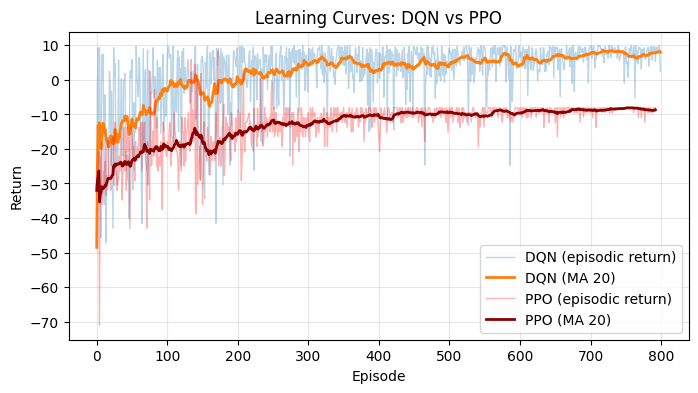

In [ ]:
print("\nPlotting reward curves...")
plot_learning_curves(dqn_returns, ppo_returns)

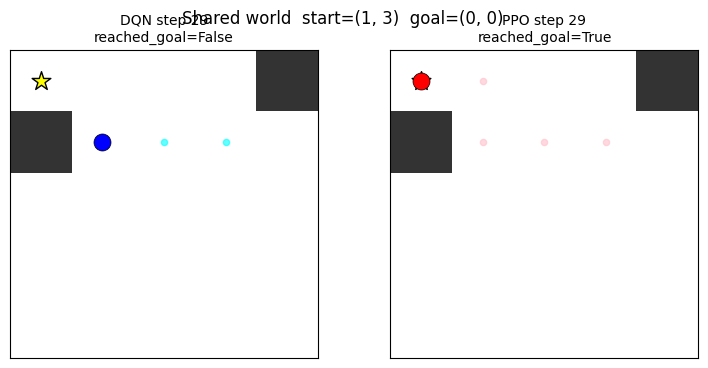

Race finished!
DQN reached goal? False
PPO reached goal? True


In [ ]:

print("\nSimulating trained policies head-to-head...")
race_and_animate(
    dqn_model,
    ppo_model,
    device=device,
    grid_size=(5,5),
    max_steps=30,
    sleep_time=0.2
)
